#                                            Simulation Final Project
#### Written by Mohammad Kamil (mk848), Carrie Rucker (cmr284), Jacob Shusko (jws383), Kevin Van Vorst (kpv23)

### Executive summary

In this experiment we modeled the progression of an epidemic taking into account how quickly infections spread between different groups of people, the time it takes for someone to heal, and how many vaccinations were available each day and how they were distributed. The population was split into different groups to represent healthcare workers, essential non-medical workers, high risk people, low risk people, and symptomatic infected people. The interactions between each of these groups were modeled uniquely thereby allowing for experimenting with class specific contact rates. Our model allows the user to tweak the rates of interactions between different groups of people, the rate at which people heal from the disease, how likely people are to become symptomatic if infected, how many vaccines can be administered per day on average, and the order in which different groups are vaccinated. 
	
We experimented with different settings of the model, and found that one of the most important first steps to reducing the number of infections and implementing a successful vaccination strategy is enforcing social distancing rules. Even a decrease by 0.5 in unnecessary meetings between people drastically reduced the number of people infected. Another important step in a vaccination strategy is to vaccinate as many people as possible each day. In simulations where more people were getting vaccinated the number of infections dropped significantly. In our experiments we found that vaccination priority order does not seem to have as much of an effect, which could be because our simulation oversimplifies the real world spread of disease. However, we did notice there was some (although not statistically significant at 95%) benefit to vaccinating people who had to interact with more people such as essential workers and healthcare workers first. Lastly, we tested the robustness of our model with respect to the healing rate chosen, because healing rate is a quantity that must be estimated and can’t be directly measured the way vaccine doses can. We found that the healing rate chosen has a pretty significant impact on how quickly infections spread. There is a tipping point at which people heal so quickly that the infections die out before they even start to spread, but before that tipping point there is a pretty steep linear increase in the number of infections as it takes longer for people to heal. This suggests that any simulation attempting to estimate how many people will be infected should take into account the margin of error in the estimate of the healing rate.



### Modeling approach, assumptions, parameters

In this model we modeled interactions among five different groups of people: medical workers, essential non-medical workers, high-risk individuals, low-risk individuals, and symptomatic infected people. Within the first four classes of people there were people who were susceptible to the disease and people who were infected but asymptomatic and kept meeting other people as normal. In the model the disease is spread through meetings between susceptible and infected people, and over time infected people will recover from the disease with a specified average time to recover. When someone recovers they can no longer infect someone or become infected, so there is no need to model their interactions with other people. When people are infected they have a certain probability of being symptomatic which depends on the class that they are in. Both asymptomatic and symptomatic infected people are capable of spreading the infection. For our default parameters, we chose $0.75$ probability for high risk individuals, $0.15$ for low risk individuals, and $0.3$ for other two groups. This is a reasonable assumption because lower risk people are less likely to become seriously ill, and higher risk are more likely. The medical worker and essential worker groups are likely to have a mix of low risk and high risk people, with a skew towards lower risk (because higher risk people tend to be older).

When choosing the rates at which different groups would interact with each other, we aimed to have a rate that would imply each person meeting roughly 5 other people per day for a higher rate, and about 1 other person per day for a lower rate. The group of symptomatic infected people were special because they only interacted with medical workers, and we aimed for that number of interactions to be about 8 per day. This is a reasonable assumption because once someone has become infected they should stop interacting with others and seek medical help. For the other four groups of people, interactions happen within the group and between each pair of groups. The higher rate of 5 interactions per day was used for meetings between healthcare workers, between essential non-medical workers, and between essential non-medical workers and every other group. The lower rate was used for all other interactions between groups. This was a reasonable assumption to make about how groups interacted because healthcare workers and essential non-medical workers still have to go to work and will interact within their groups. Essential non-medical workers will also have a higher level of interaction with everyone since they’re doing things like working at grocery stores.

Another aspect of the model is the vaccination program, which has two components: The average number of people who can be vaccinated per day, and the priority order in which people can be vaccinated. Vaccines are administered to people who are still susceptible, and once someone is vaccinated they immediately become resistant to the disease. The average number of people vaccinated per day can be adjusted based on the number of vaccines that are expected to be available. We made the default setting for vaccinations be a random vaccination order, but the model can also be adjusted so that everyone who is susceptible in a certain class is vaccinated first, and then the susceptible people in the next highest priority class are vaccinated, and so on. For example, a reasonable priority order might be vaccinating healthcare workers, essential workers, high risk individuals, and then low risk individuals.

### Model details

Our model was implemented as a Markov chain, and all events were implemented as independent Poisson processes. There were four classes in the Markov model; $C1$ represented medical workers, $C2$ represented essential non-medical workers, $C3$ represented high risk individuals, and $C4$ represented everyone else, with different variables to keep track of people in those groups who were susceptible and infected but asymptomatic. There were also separate variables to keep track of people who were infected and symptomatic and people who were recovered. The time between meetings for all the groups were Poisson processes with rates given by the high and low rates and rate for meetings between healthcare workers and symptomatic infected people as described in the modeling approach section. Each rate of meeting passed into the function is for the rate between two people, so it must be scaled to include all the meetings that could happen between the two groups. In our simulation we only calculated productive meetings (i.e. meetings between a susceptible and an infected person) because all other meetings could be safely ignored. When a person becomes infected, they are symptomatic with a certain probability $p_i$ where $i$ is the class (1, 2, 3, or 4) that they belong to. 

The rate of healing is determined by a rate $\beta$ which is scaled by the number of people who are infected. The rate of vaccines being administered is a constant number $\gamma$ because the number of vaccines available doesn’t change based on how many people are susceptible or infected.

All of the different rates of events are summed and the sum is used to calculate the time of the next event using an exponential random variable. This works because the minimum of exponential random variables is also an exponential random variable with its rate equal to the sum of all rates. Additionally, an exponential random variables clock can be restarted at any time without any effect because exponential random variables are memoryless.

The priority order for vaccines is implemented as a list. When a vaccine is distributed, the model will check which group of people is at the front of the list, and vaccinate one susceptible person from that group. If there are no more susceptible people in that group, that group is removed from the front of the list and a susceptible person in the next group in line will receive the vaccine. If there are no more susceptible in the simulation, no one receives the vaccine.

### Model analysis and recommendations

In [35]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.linear_model import LinearRegression
from IPython.display import clear_output
from time import sleep
import random
import copy

import vaccine_model

%matplotlib inline
master_seed = 1
iters = 10

figsizex = 20
figsizey = 10
xlabelsize = 16
ylabelsize = xlabelsize
titlesize = 20

In [34]:
n = 10000
n1 = 0.1 * n
n2 = 0.2 * n
n3 = 0.1 * n
n4 = 0.6 * n

p1 = 0.3
p2 = 0.3
p3 = 0.75
p4 = 0.15

h = 5 / n
l = 1 / n
lambda_is = 8 / n
lambda_matrix = np.array([[h,h,l,l],[0,h,h,h],[0,0,l,l],[0,0,0,l]])

gamma = 50

beta = 1.5

priority_order = []

One run with default settings:

In [3]:
np.random.seed(master_seed)
clks, c1_infs, c2_infs, c3_infs, c4_infs, Is_infs, c1_Ss, c2_Ss, c3_Ss, c4_Ss, Rs, total_infected = \
vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                           p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                           gamma=gamma, beta=beta, priority_order=priority_order)

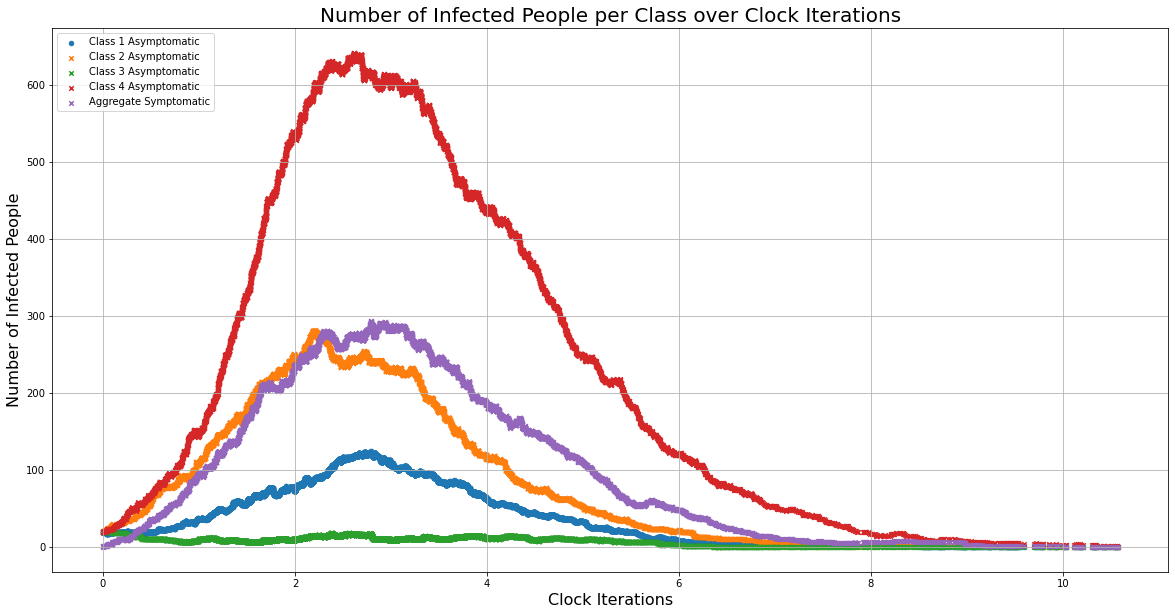

In [4]:
fig = plt.figure(figsize=(figsizex,figsizey))
ax1 = fig.add_subplot(111)

ax1.scatter(clks, c1_infs, s=20, marker="o", label='Class 1 Asymptomatic')
ax1.scatter(clks,c2_infs, s=20, marker="x", label='Class 2 Asymptomatic')
ax1.scatter(clks, c3_infs, s=20, marker="x", label='Class 3 Asymptomatic')
ax1.scatter(clks,c4_infs, s=20, marker="x", label='Class 4 Asymptomatic')
ax1.scatter(clks,Is_infs, s=20, marker="x", label='Aggregate Symptomatic')
plt.legend(loc='upper left');
plt.ylabel('Number of Infected People',size=ylabelsize)
plt.xlabel('Clock Iterations',size=xlabelsize)
plt.title("Number of Infected People per Class over Clock Iterations",size=titlesize)
plt.grid(True)
plt.show()

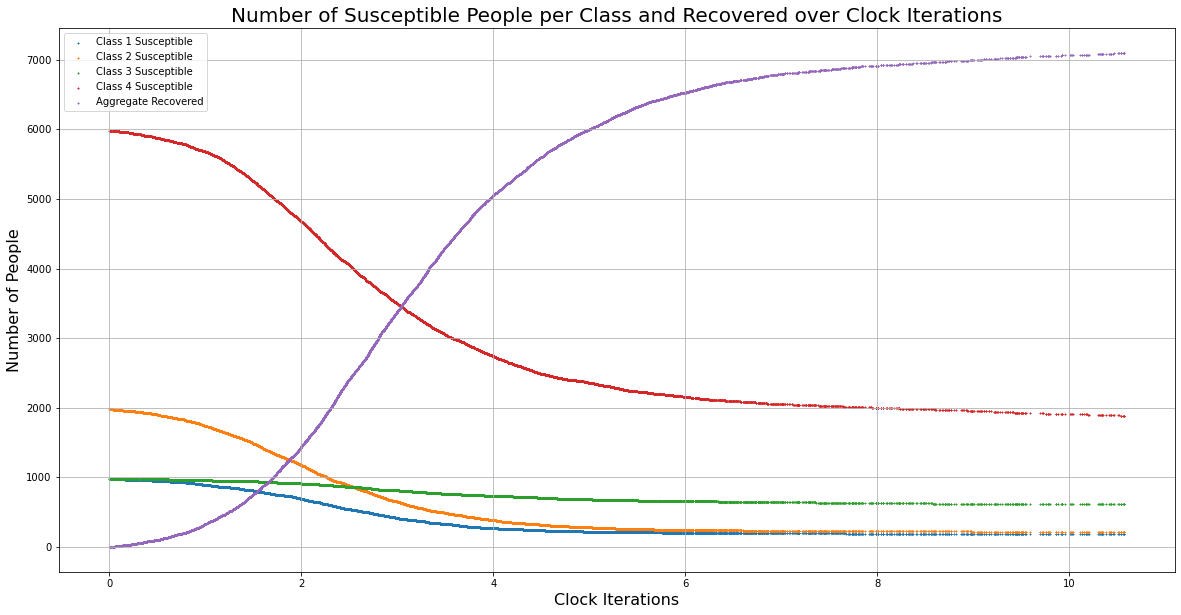

In [5]:
fig = plt.figure(figsize=(figsizex,figsizey))
ax1 = fig.add_subplot(111)

ax1.scatter(clks, c1_Ss, s=1, marker="x", label='Class 1 Susceptible')
ax1.scatter(clks,c2_Ss, s=1, marker="x", label='Class 2 Susceptible')
ax1.scatter(clks, c3_Ss, s=1, marker="x", label='Class 3 Susceptible')
ax1.scatter(clks,c4_Ss, s=1, marker="x", label='Class 4 Susceptible')
ax1.scatter(clks,Rs, s=1, marker="x", label='Aggregate Recovered')
plt.legend(loc='upper left');
plt.ylabel('Number of People',size=ylabelsize)
plt.xlabel('Clock Iterations',size=xlabelsize) 
plt.title("Number of Susceptible People per Class and Recovered over Clock Iterations",size=titlesize)
plt.grid(True)
plt.show()

Finding mean number of infected people with default settings:

In [6]:
np.random.seed(master_seed)
total_infs_list = np.zeros(shape=iters)
for i in range(iters):
    _, _, _, _, _, _, _, _, _, _, _, total_infs = \
    vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                           p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                           gamma=gamma, beta=beta, priority_order=priority_order)
    total_infs_list[i] = total_infs

avg = np.mean(total_infs_list)
err = stats.norm.ppf(0.975)*np.sqrt(np.var(total_infs_list)/iters)
print(f"The mean number of people infected out of {n} with default settings is {avg} with 95% CI {avg-err, avg+err}")

The mean number of people infected out of 10000 with default settings is 6428.9 with 95% CI (6372.590367753551, 6485.209632246449)


### Testing the effects of social distancing
In order to test the effects of social-distancing on the number of people infected, we varied the high and low meeting rates between the default value and one tenth of the default value, which is equivalent to people reducing the number of people that they interact with by a factor of ten. We left the meeting rate between symptomatic infected people and healthcare workers unchanged, because healthcare workers would still need to care for people who are sick. As one would expect, as people were more rigorous about social distancing, the total number of infected people dropped dramatically. The most significant change came from lowering the “low” rate of meetings. Even just reducing the low rate by 0.5 produced a dramatic dropoff in the number of infections, indicating that an important first step in a successful vaccination program is to convince people to cut out unnecessary meetings with other people.

In [7]:
np.random.seed(master_seed)
h_vals = h / np.arange(1,10)
l_vals = l / np.arange(1,10)

social_dist_inf_means = np.zeros(shape=(len(h_vals), len(l_vals)))
social_dist_inf_errs = np.zeros(shape=(len(h_vals), len(l_vals)))

for h_ind in range(len(h_vals)):
    for l_ind in range(len(l_vals)):
        h1 = h_vals[h_ind]
        l1 = l_vals[l_ind]
        lambda_matrix1 = np.array([[h1,h1,l1,l1],[0,h1,h1,h1],[0,0,l1,l1],[0,0,0,l1]])
        temp_infs = np.zeros(iters)
        for i in range(iters):
            _, _, _, _, _, _, _, _, _, _, _, total_infs = \
            vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix1, lambda_is=lambda_is, \
                                   p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                                   gamma=gamma, beta=beta, priority_order=priority_order)
            temp_infs[i] = total_infs
            
        social_dist_inf_means[h_ind,l_ind] = np.mean(temp_infs)
        social_dist_inf_errs[h_ind,l_ind] = stats.norm.ppf(0.975)*np.sqrt(np.var(temp_infs)/iters)


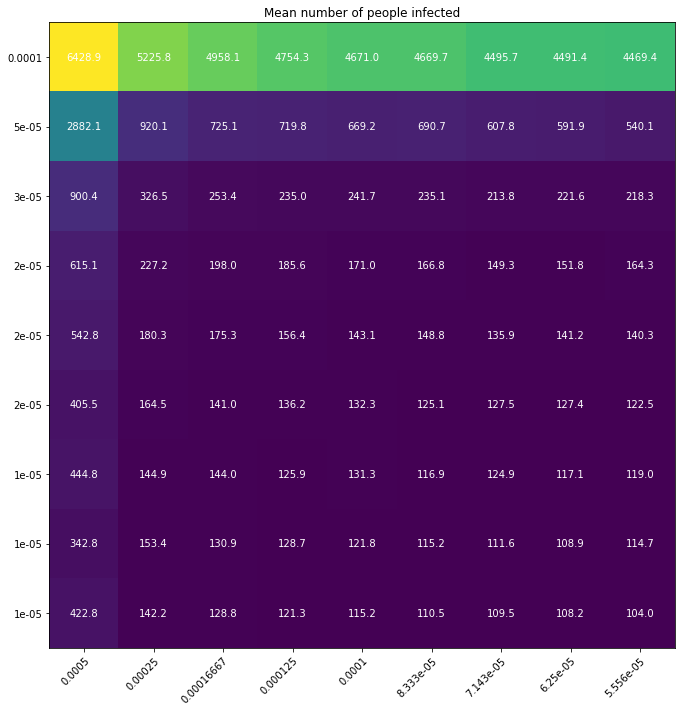

In [8]:
#code adapted from example on matplotlib.org
fig, ax = plt.subplots(figsize=(figsizex,figsizey))
im = ax.imshow(social_dist_inf_means)

h_vals = np.around(h_vals,decimals=8)
l_vals = np.around(l_vals,decimals=5)
vals_to_show = str()

ax.set_xticks(np.arange(len(h_vals)))
ax.set_yticks(np.arange(len(l_vals)))

ax.set_xticklabels(h_vals)
ax.set_yticklabels(l_vals)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(l_vals)):
    for j in range(len(h_vals)):
        text = ax.text(j, i, social_dist_inf_means[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Mean number of people infected")
fig.tight_layout()

plt.show()

The 95% confidence interval margins of error for these mean values are:

In [9]:
print(social_dist_inf_errs)

[[ 56.30963225  57.50535667 133.38370701  66.816118    77.16435706
   98.09264358  97.77924224 136.06475971 129.21387181]
 [182.92154968 171.12213095 116.52985608 102.99859694 154.56271508
  182.87609878  68.97112983  93.56501434 120.02485628]
 [167.72258241  33.77882926  33.44390103  39.30790718  37.76179757
   29.10721391  32.90148522  22.41945222  39.11888773]
 [ 74.31104647  21.1908275   11.93165805  16.83105877  19.12748123
   13.10921439  12.45171151  10.50292014  17.50863374]
 [102.63244311  20.83663882  19.40275253  10.7466096   16.13242058
   14.57717861  10.17464858   8.42009287   8.22274387]
 [ 65.78665171  19.20814703   9.13435743   5.95648501  11.11854245
    8.64808428  10.61008722   6.79630053   8.48576134]
 [ 62.36493294   5.03867059   9.89733297   5.6155619   10.30818085
    4.78849326   9.14045337   6.4794524    8.37526346]
 [ 56.16574239  12.02849554   6.76939896   6.0919893    6.2951163
    4.98771364   4.45390765   6.21929649   6.53611992]
 [ 96.22437144  10.971597

### Testing the effects of the vaccination rate ($\gamma$)

In order to investigate the effects of the vaccination rate on the total number of people infected, we varied the gamma parameter from 1 to 10000 with a step size of 500. All other parameters in the simulation remained unchanged from the default setting. As expected, increasing the gamma value led to a decrease in the total number of people infected across all classes. With `gamma = 1`, approximately 115 people were infected and this decreased to approximately 80 people at a gamma rate of 10000. Vaccinating rigorously clearly drives the infected number of people drastically making the vaccination rate a vital parameter when experimenting its effect on the default setting. 

In [39]:
np.random.seed(master_seed)
gamma_vals = np.arange(1,10001,500)

vaccine_rate_inf_means = np.zeros(len(gamma_vals))
vaccine_rate_inf_errs = np.zeros(len(gamma_vals))
   
for vaccine_index in range(len(gamma_vals)):
    gamma = gamma_vals[vaccine_index]
    temp_infs = np.zeros(iters)
    for i in range(iters):
        _, _, _, _, _, _, _, _, _, _, _, total_infs = \
            vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                                   p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                                   gamma=gamma, beta=beta, priority_order=priority_order)
        temp_infs[i] = total_infs 
    
    vaccine_rate_inf_means[vaccine_index] = np.mean(temp_infs)
    vaccine_rate_inf_errs[vaccine_index] = stats.norm.ppf(0.975)*np.sqrt(np.var(temp_infs)/iters)


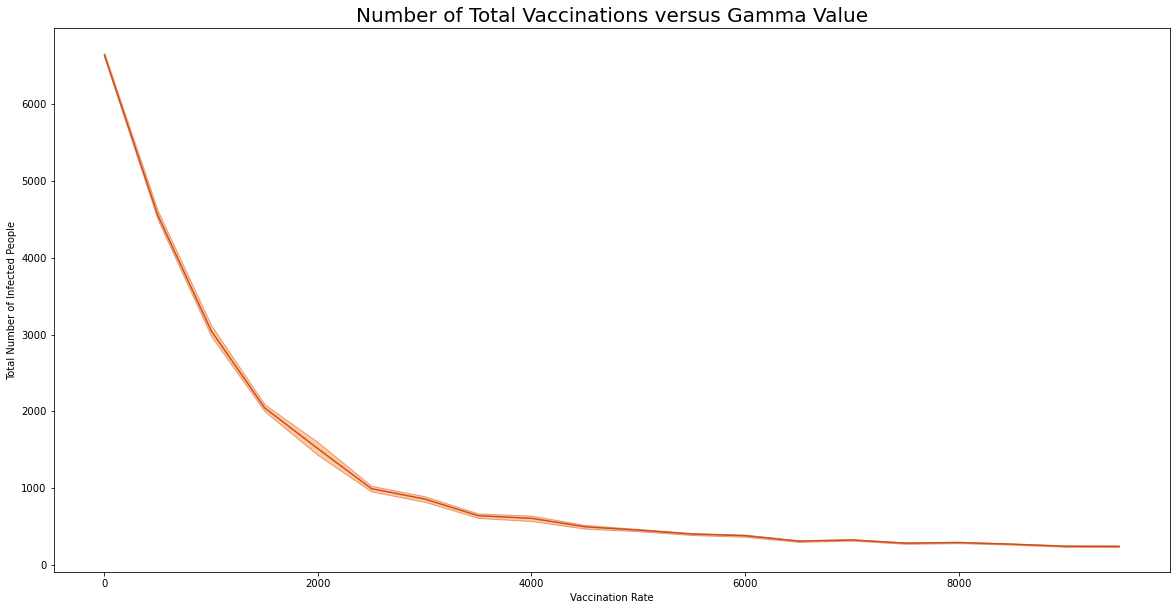

In [40]:
plt.figure(figsize=(figsizex,figsizey))
plt.plot(gamma_vals,vaccine_rate_inf_means, color='#CC4F1B')
plt.ylabel('Total Number of Infected People')
plt.xlabel('Vaccination Rate')
plt.title("Number of Total Vaccinations versus Gamma Value",size=titlesize)
plt.fill_between(gamma_vals, vaccine_rate_inf_means-vaccine_rate_inf_errs/2, vaccine_rate_inf_means+vaccine_rate_inf_errs/2, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

### Testing the effects of Priority Vaccinations 

The amount of total infections was observed by running simulations with different vaccination priority orders. Since there are 4 classes of people, that means 24 permutations of the vaccination order can be inputted to the simulation. The rest of the settings were set to the original default values we specified in the beginning. For each priority order, the total infections were averaged over all simulations, as well as each class’ maximum number of infections during the simulations. If the priority order were to make a difference, we should see a difference in total number of infections and the peak number of infections in each class. After simulating all possible orders, it was very clear that with our model no priority order did much better than the rest. 

The best priority order is ['c1', 'c4', 'c3', 'c2'].


Text(0.5, 1.0, 'Effect of Vaccination Priority Queue on Total Number of Infections')

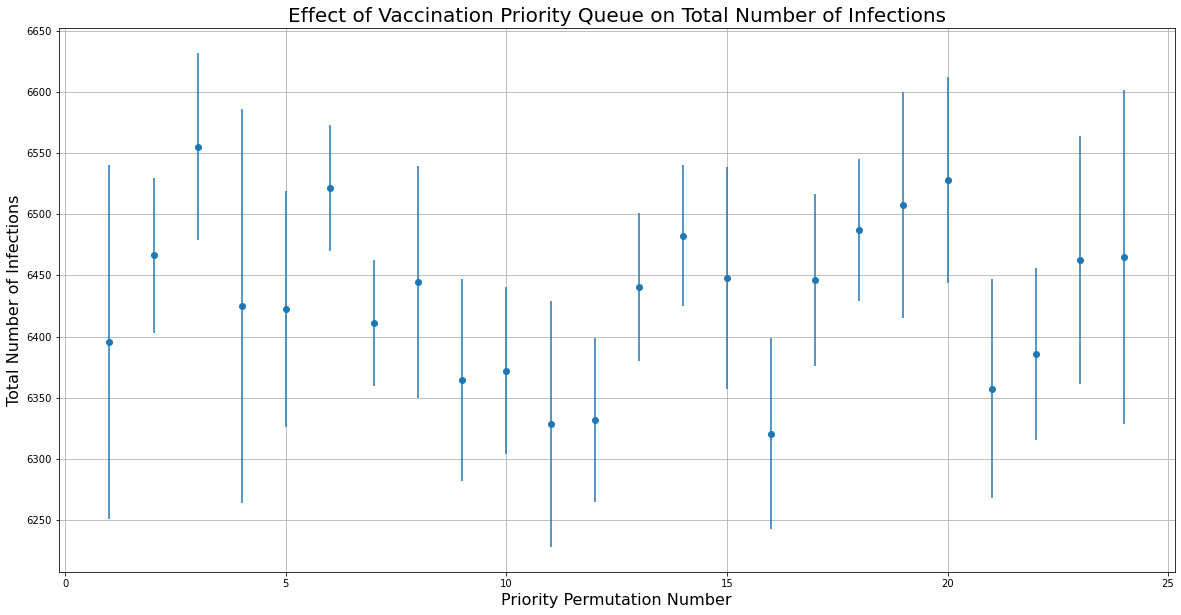

In [15]:
np.random.seed(master_seed)
all_priority_orders = [["c1","c2","c3","c4"],["c2","c1","c3","c4"],["c3","c1","c2","c4"],["c1","c3","c2","c4"],
                       ["c2","c3","c1","c4"],["c3","c2","c1","c4"],["c4","c2","c1","c3"],["c2","c4","c1","c3"],
                       ["c1","c4","c2","c3"],["c4","c1","c2","c3"],["c2","c1","c4","c3"],["c1","c2","c4","c3"],
                       ["c1","c3","c4","c2"],["c3","c1","c4","c2"],["c4","c1","c3","c2"],["c1","c4","c3","c2"],
                       ["c3","c4","c1","c2"],["c4","c3","c1","c2"],["c4","c3","c2","c1"],["c3","c4","c2","c1"],
                       ["c2","c4","c3","c1"],["c4","c2","c3","c1"],["c3","c2","c4","c1"],["c2","c3","c4","c1"]]
all_priority_orders_copy = copy.deepcopy(all_priority_orders)
totalinfs = []
error = []
for i in range(len(all_priority_orders_copy)):
    temp = []
    for j in range(iters):
        _, _, _, _, _, _, _, _, _, _, _, total_infs = vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                                       p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                                       gamma=gamma, beta=beta, priority_order=all_priority_orders_copy[i])
        temp.append(total_infs)
    totalinfs.append(np.mean(temp))
    error.append(stats.norm.ppf(0.975)*np.sqrt(np.var(temp)/iters))
    
max_index = totalinfs.index(max(totalinfs))
max_pri_order = all_priority_orders[max_index]
min_index = totalinfs.index(min(totalinfs))
min_pri_order = all_priority_orders[min_index]
print(f"The best priority order is {min_pri_order}.")

plt.figure(figsize=(figsizex,figsizey))
plt.errorbar(np.arange(1,25,1),totalinfs,yerr=error,ls="",marker="o")
plt.grid(True)
plt.xlabel("Priority Permutation Number",size=xlabelsize)
plt.ylabel("Total Number of Infections",size=ylabelsize)
plt.title("Effect of Vaccination Priority Queue on Total Number of Infections",size=titlesize)

In [16]:
#c1
c1infs = []
all_priority_orders_copy = copy.deepcopy(all_priority_orders)
for i in range(len(all_priority_orders_copy)):
    temp = []
    for j in range(iters):
        _, c1_infs, _, _, _, _, _, _, _, _, _, _ = vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                                       p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                                       gamma=gamma, beta=beta, priority_order=all_priority_orders_copy[i])
        temp.append(max(c1_infs))
    c1infs.append(np.mean(temp))
print(c1infs)

[114.3, 119.5, 116.4, 113.1, 116.7, 109.9, 114.0, 114.6, 117.0, 123.3, 115.2, 116.9, 110.7, 114.0, 113.9, 110.6, 115.5, 114.2, 117.7, 118.6, 117.1, 112.0, 107.6, 119.8]


In [17]:
#c2
c2infs = []
all_priority_orders_copy = copy.deepcopy(all_priority_orders)
for i in range(len(all_priority_orders_copy)):
    temp = []
    for j in range(iters):
        _, _, c2_infs, _, _, _, _, _, _, _, _, _ = vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                                       p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                                       gamma=gamma, beta=beta, priority_order=all_priority_orders_copy[i])
        temp.append(max(c2_infs))
    c2infs.append(np.mean(temp))
print(c2infs)

[248.5, 264.5, 242.1, 262.3, 246.5, 249.5, 242.8, 255.7, 257.3, 250.8, 258.0, 246.4, 253.0, 253.9, 255.0, 258.9, 247.3, 248.6, 253.8, 256.2, 261.9, 261.6, 257.6, 241.4]


In [18]:
#c3
c3infs = []
all_priority_orders_copy = copy.deepcopy(all_priority_orders)
for i in range(len(all_priority_orders_copy)):
    temp = []
    for j in range(iters):
        _, _, _, c3_infs, _, _, _, _, _, _, _, _ = vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                                       p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                                       gamma=gamma, beta=beta, priority_order=all_priority_orders_copy[i])
        temp.append(max(c3_infs))
    c3infs.append(np.mean(temp))
print(c3infs)

[20.3, 20.0, 20.2, 20.6, 20.0, 20.2, 20.8, 20.2, 20.1, 20.4, 20.6, 20.5, 20.1, 20.4, 20.2, 20.6, 20.2, 20.4, 20.2, 20.2, 20.5, 20.1, 20.4, 21.0]


In [19]:
#c4
c4infs = []
all_priority_orders_copy = copy.deepcopy(all_priority_orders)
for i in range(len(all_priority_orders_copy)):
    temp = []
    for j in range(iters):
        _, _, _, _, c4_infs, _, _, _, _, _, _, _ = vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                                       p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                                       gamma=gamma, beta=beta, priority_order=all_priority_orders_copy[i])
        temp.append(max(c4_infs))
    c4infs.append(np.mean(temp))
print(c4infs)

[593.7, 576.4, 591.2, 619.7, 590.9, 594.3, 591.2, 609.1, 580.3, 580.0, 569.6, 573.9, 596.8, 596.7, 590.5, 565.7, 598.6, 553.8, 579.2, 594.0, 576.9, 562.2, 593.8, 598.7]


Not only were the means of the simulations of each priority order similar, their corresponding 95% confidence intervals also overlapped each other. Therefore we are unable to statistically prove which vaccination priority order is the best. However, the observed best and worst performing vaccination strategies logically make sense. Our best strategy resulted on average with the order $C_1 \rightarrow C_4 \rightarrow C_3 \rightarrow C_2$. We would want to first vaccinate the essential workers who have a high meeting rate ($\lambda = h$) or more exposure to the virus. Perhaps our model is not complex enough to capture the complexity of human interactions since we categorized people into 4 categories with fixed amounts of interaction between each other. 

### Effect of Beta 

In order to evaluate the robustness of our model, we explored the effect of beta on the experiment. Considering this parameter should have predictable effects on the simulation, we wanted to confirm this was following our intuition. In order to explore this, we used the default parameters as specified above with the exception of beta. For this experiment, we looked at values of beta ranging from 0 to 10 with all others fixed and plotted the total number of infected and recovered people, which includes the vaccinated. As seen in the plot below, increasing beta reduces both the total number of infected and recovered. Intuitively, this makes sense because if infected people are healing quicker, there is less time for each infected person to have meetings, so there is less infected and thus less possible recoveries. The default value of beta allows for a majority infection, which is realistic of pandemics given our model is examining the population of a small town (`n=10000`).

In [22]:
np.random.seed(master_seed)
betas = np.arange(0.5,8,step=0.2)

data_infs, errs_infs = [], []
data_Rs, errs_Rs = [], []
for beta3 in betas:
    temp_Rs = np.zeros(iters)
    temp_infs = np.zeros(iters)
    for i in range(iters):
        _, _, _, _, _, _, _, _, _, _, Rs, total_infs = \
        vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                               p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                               gamma=gamma, beta=beta3, priority_order=priority_order)
        temp_infs[i] = total_infs
        temp_Rs[i] = Rs[-1]
    errs_infs.append(stats.norm.ppf(0.975)*np.sqrt(np.var(temp_infs)/iters))
    data_infs.append(np.mean(temp_infs))
    errs_Rs.append(stats.norm.ppf(0.975)*np.sqrt(np.var(temp_Rs)/iters))
    data_Rs.append(np.mean(temp_Rs))

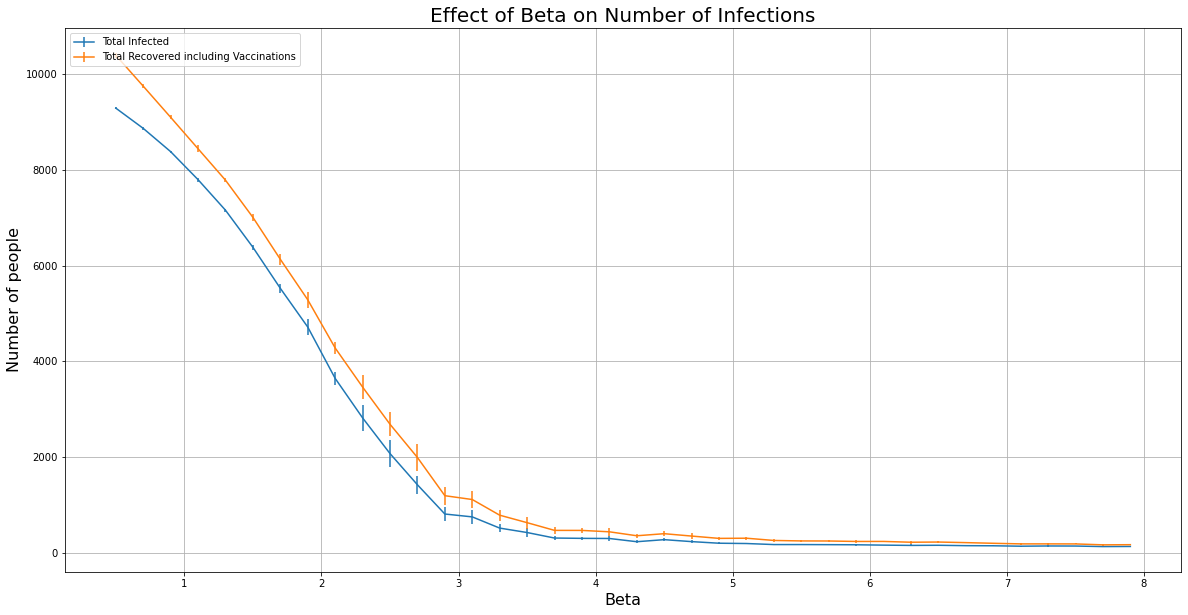

In [23]:
plt.figure(figsize=(figsizex,figsizey))
plt.errorbar(x=betas,y=data_infs,yerr=errs_infs,label="Total Infected")
plt.errorbar(x=betas,y=data_Rs,yerr=errs_Rs,label="Total Recovered including Vaccinations")
plt.legend(loc='upper left')
plt.title("Effect of Beta on Number of Infections",size=titlesize)
plt.ylabel('Number of people',size=ylabelsize)
plt.xlabel('Beta',size=xlabelsize)
plt.grid(True)

After validating our intuition, we decided to make one more check: running the simulation with gamma set to zero. In this case, we should expect the number of infected to be equal to the number of recovered individuals. As seen in the plot below, this matches our intuition. 

In [30]:
np.random.seed(master_seed)
betas = np.arange(0.5,8,step=0.2)

data_infs, errs_infs = [], []
data_Rs, errs_Rs = [], []
for beta3 in betas:
    temp_Rs = np.zeros(iters)
    temp_infs = np.zeros(iters)
    for i in range(iters):
        _, _, _, _, _, _, _, _, _, _, Rs, total_infs = \
        vaccine_model.sir_with_vaccine_clustered(lambda_matrix=lambda_matrix, lambda_is=lambda_is, \
                               p1=p1, p2=p2, p3=p3, p4=p4, n1=n1, n2=n2, n3=n3, n4=n4, \
                               gamma=0, beta=beta3, priority_order=priority_order)
        temp_infs[i] = total_infs
        temp_Rs[i] = Rs[-1]
    errs_infs.append(stats.norm.ppf(0.975)*np.sqrt(np.var(temp_infs)/iters))
    data_infs.append(np.mean(temp_infs))
    errs_Rs.append(stats.norm.ppf(0.975)*np.sqrt(np.var(temp_Rs)/iters))
    data_Rs.append(np.mean(temp_Rs))

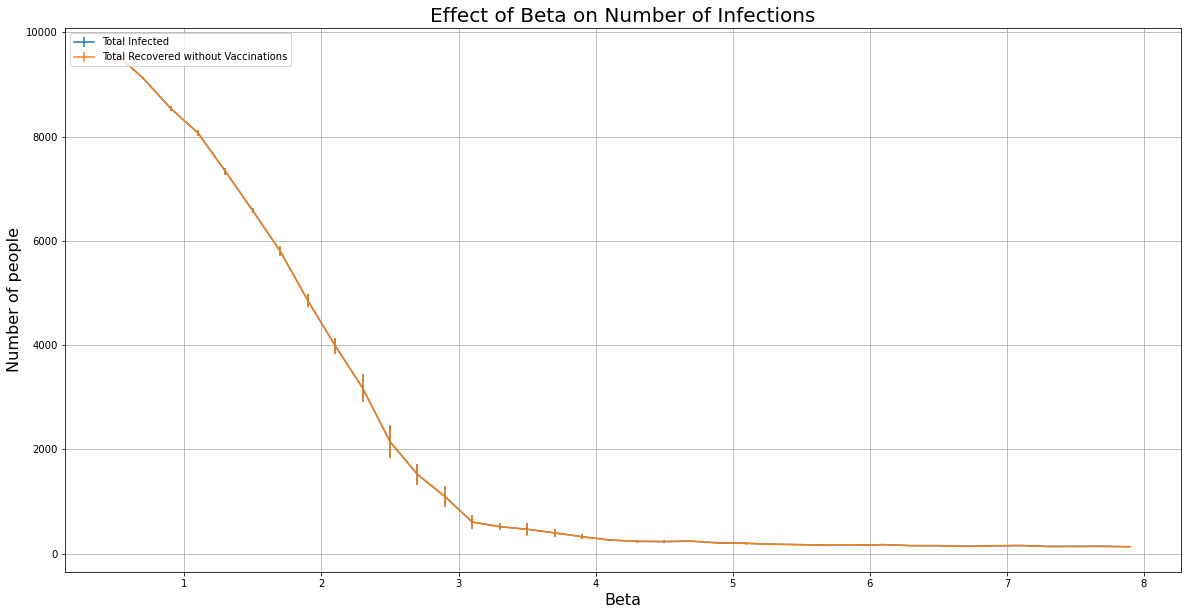

In [31]:
plt.figure(figsize=(figsizex,figsizey))
plt.errorbar(x=betas,y=data_infs,yerr=errs_infs,label="Total Infected")
plt.errorbar(x=betas,y=data_Rs,yerr=errs_Rs,label="Total Recovered without Vaccinations")
plt.legend(loc='upper left')
plt.title("Effect of Beta on Number of Infections",size=titlesize)
plt.ylabel('Number of people',size=ylabelsize)
plt.xlabel('Beta',size=xlabelsize)
plt.grid(True)

### Conclusions
Running a few experiments on our model revealed a variety of useful or uninformative results. Social distancing and mass vaccination proved to be the most effective methods in slowing down the spread and eradicating the virus. On the other hand, our model could not determine a definite answer for the best vaccination priority strategy. This model we have developed provides a solid starting point for exploring the complexities of epidemics. 

There are many possible further extensions to the model. A definite limitation is that our model does not take data in as input, other than manually pre-specified values. For example, beta is given and this quantity should be measured on data acquired from actual epidemics. A front-end for this vaccine model that takes epidemic data and parameterizes the model with respect to certain demographics, locality and epidemic traits would be a valuable addition.  

### Technical appendices

#### Inputs to the model:

`lambda_matrix`: a 4x4 matrix representing rates of meeting between and within group $C1$, $C2$, $C3$, and $C4$. `lambda_matrix` is an upper triangular matrix because interaction rates between groups only need to be specified once. (If there are values outside of the upper triangle they will be ignored). Although each rate can be individually specified, we recommend specifying one high value and one low value and using the high rate of interaction within $C1$ and $C2$ and between $C2$ and every other group, and the low rate of interaction for every other pair. This would be equivalent to the following matrix: `[[h,h,l,l],[0,h,h,h],[0,0,l,l],[0,0,0,l]]`

`lambda_is`: The rate of interaction between healthcare workers ($C1$) and symptomatic infected people. This should be a relatively high rate because healthcare workers must care for the sick

`p1`: The probability that someone in $C1$ is symptomatic when they become infected

`p2`: The probability that someone in $C2$ is symptomatic when they become infected

`p3`: The probability that someone in $C3$ is symptomatic when they become infected

`p4`: The probability that someone in $C4$ is symptomatic when they become infected

`n1`:  The total number of people within $C1$ = medical workers

`n2`:  The total number of people within $C2$ = essential non-medical workers

`n3`:  The total number of people within $C3$ = non-essential high-risk

`n4`:  The total number of people within $C4$ = non-essential low-risk

`gamma`: The vaccination rate per day (the average number of people who can be vaccinated each day)

`beta`:  The rate at which infected people migrate to the recovered class R (the healing rate)

`priority_order`: A list of the classes specifying in which order people should be vaccinated. An empty list will vaccinate people in a random order. For example, the list `[“C1”, “C2”, “C3”, “C4”]` will vaccinate all susceptible people in $C1$, then all susceptible people in $C2$, etc.

#### Outputs of the model:

`clks`: A list containing the times that each event occurred

`c1_infs`: A list with the number of asymptomatic infections in class $C1$ at each time in `clks`

`c2_infs`: A list with the number of asymptomatic infections in class $C2$ at each time in `clks`

`c3_infs`: A list with the number of asymptomatic infections in class $C3$ at each time in `clks`

`c4_infs`: A list with the number of asymptomatic infections in class $C4$ at each time in `clks`

`Is_infs`: A list with the number of symptomatic infections at each time in `clks`

`c1_Ss`: A list with the number of susceptible people in class $C1$ at each time in `clks`

`c2_Ss`: A list with the number of susceptible people in class $C2$ at each time in `clks`

`c3_Ss`: A list with the number of susceptible people in class $C3$ at each time in `clks`

`c4_Ss`: A list with the number of susceptible people in class $C4$ at each time in `clks`

`Rs`: A list with the number of recovered people at each time in `clks`

`total_infected`: The total number of people who became infected 